In [1]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

# Pre-training results


In [2]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np
import pandas as pd
import toml
import os

# from presentation.pipelines.steps.load_data import build_loader
# from presentation.pipelines.steps.model_design import load_pt_model

from src.utils import tensorboard_logs

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

2024-08-05 00:01:00.691899: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 00:01:00.691963: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 00:01:00.691988: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 00:01:00.699618: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model_paths = ['./presentation/results/macho_100/2024-07-18_18-21-35/pretraining/',
               './presentation/results/macho_1000/2024-07-18_20-15-41/pretraining/',
               './presentation/results/macho_10000/2024-07-18_20-16-07/pretraining/',
               './presentation/results/macho_100000/2024-07-19_10-03-35/pretraining/',
               './presentation/results/macho_500000/2024-07-23_14-47-04/pretraining/',
               './presentation/results/macho_750000/2024-07-23_14-45-39/pretraining/',
               './presentation/results/macho_1000000/2024-07-23_14-46-24/pretraining',
              './presentation/results/macho_500000/2024-07-30_09-04-21/pretraining',
               './presentation/results/macho_500000/2024-07-30_09-04-45/pretraining',
               './presentation/results/macho_500000/2024-07-23_14-47-04/pretraining/']

# model_paths = ['./presentation/results/macho_500000/2024-07-30_09-04-21/pretraining',
#                './presentation/results/macho_500000/2024-07-30_09-04-45/pretraining',
#                './presentation/results/macho_500000/2024-07-23_14-47-04/pretraining/']

In [37]:
x_plot, y1_plot, y2_plot = [], [], []
for logs in model_paths:
    train_metrics, val_metrics = tensorboard_logs(logs)
    row = val_metrics[val_metrics['loss'] == val_metrics['loss'].min()]
    y1_plot.append(float(row['rmse'].values[0]))
    y2_plot.append(float(row['square'].values[0]))
    x_plot.append(row['exp_name'].values[0].split('_')[-1]+str(row['probed'].values[0]))

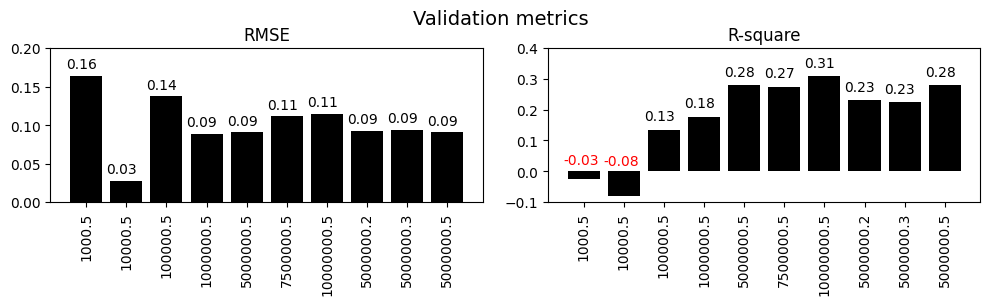

In [90]:
fig, axes = plt.subplots(1, 2, dpi=100, figsize=(12, 2), gridspec_kw={'wspace': 0.15})
xticks = range(len(x_plot))
axes[0].bar(xticks, y1_plot, color='k')
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(x_plot, rotation=90)
axes[0].set_title('RMSE')
for i, value in enumerate(y1_plot):
    axes[0].text(i-.5, value+0.01, '{:.2f}'.format(value))
axes[0].set_ylim(0., 0.20)

axes[1].bar(xticks, y2_plot, color='k')
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(x_plot, rotation=90)
for i, value in enumerate(y2_plot):
    if i == 0:
        axes[1].text(i-.5, value+0.05, '{:.2f}'.format(value), color='red')
    elif i == 1:
        axes[1].text(i-.5, value+0.1, '{:.2f}'.format(value), color='red')
    else:
        axes[1].text(i-.5, value+0.03, '{:.2f}'.format(value))
# axes[1].set_yticks(y2_plot)
axes[1].set_ylim(-0.1, 0.40)
axes[1].set_title('R-square')

fig.text(0.5, 1., 'Validation metrics', ha='center', fontsize=14)

plt.show()

### Test set

In [58]:
# path = './presentation/results/macho_100/2024-07-18_18-21-35/pretraining/results.csv'
test_metrics_pt = []
for path in model_paths:
    curr = os.path.join(path, 'results.csv')
    test_metrics_pt.append(pd.read_csv(curr))
test_metrics_pt = pd.concat(test_metrics_pt)    

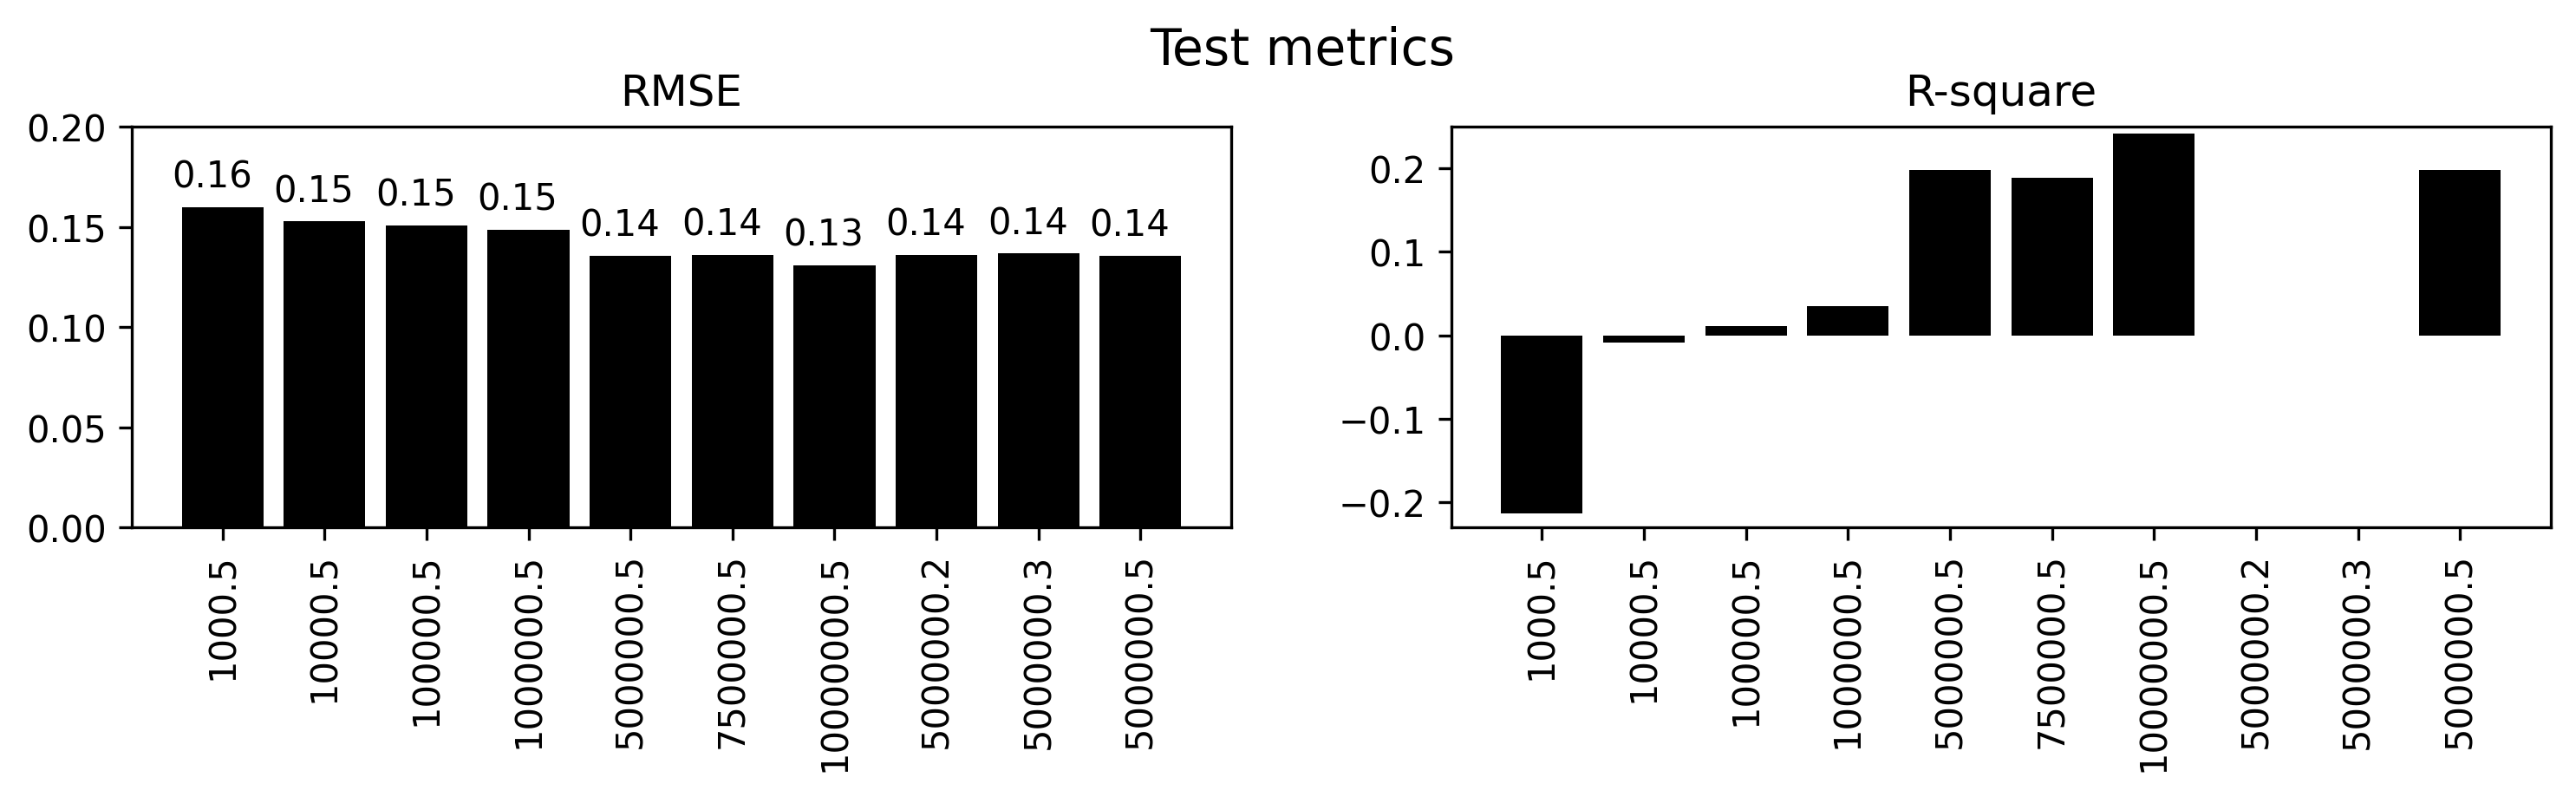

In [91]:
labels = [x.split('_')[-1]+str(p) for x, p in zip(test_metrics_pt['exp_name'].values, test_metrics_pt['probed'].values)]

fig, axes = plt.subplots(1, 2, dpi=300, figsize=(12, 2))
xticks = range(len(labels))
axes[0].bar(xticks, test_metrics_pt['test_mse'], color='k')
axes[0].set_title('RMSE')
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(labels, rotation=90)
axes[0].set_ylim(0., 0.20)
for i, value in enumerate(test_metrics_pt['test_mse']):
    axes[0].text(i-.5, value+0.01, '{:.2f}'.format(value))

axes[1].bar(xticks, test_metrics_pt['test_r2'], color='k')
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(labels, rotation=90)
axes[1].set_ylim(-0.23, 0.25)
axes[1].set_title('R-square')
fig.text(0.5, 1., 'Test metrics', ha='center', fontsize=14)
plt.show() 

### Classification

In [65]:
from presentation.pipelines.pipeline_0.utils import classification_metrics

In [66]:
test_metrics = []
for root in model_paths:
    curr = classification_metrics(os.path.join(root, '..'), spc_list=[20, 100, 500])
    test_metrics.append(curr)
    
test_metrics = pd.concat(test_metrics)

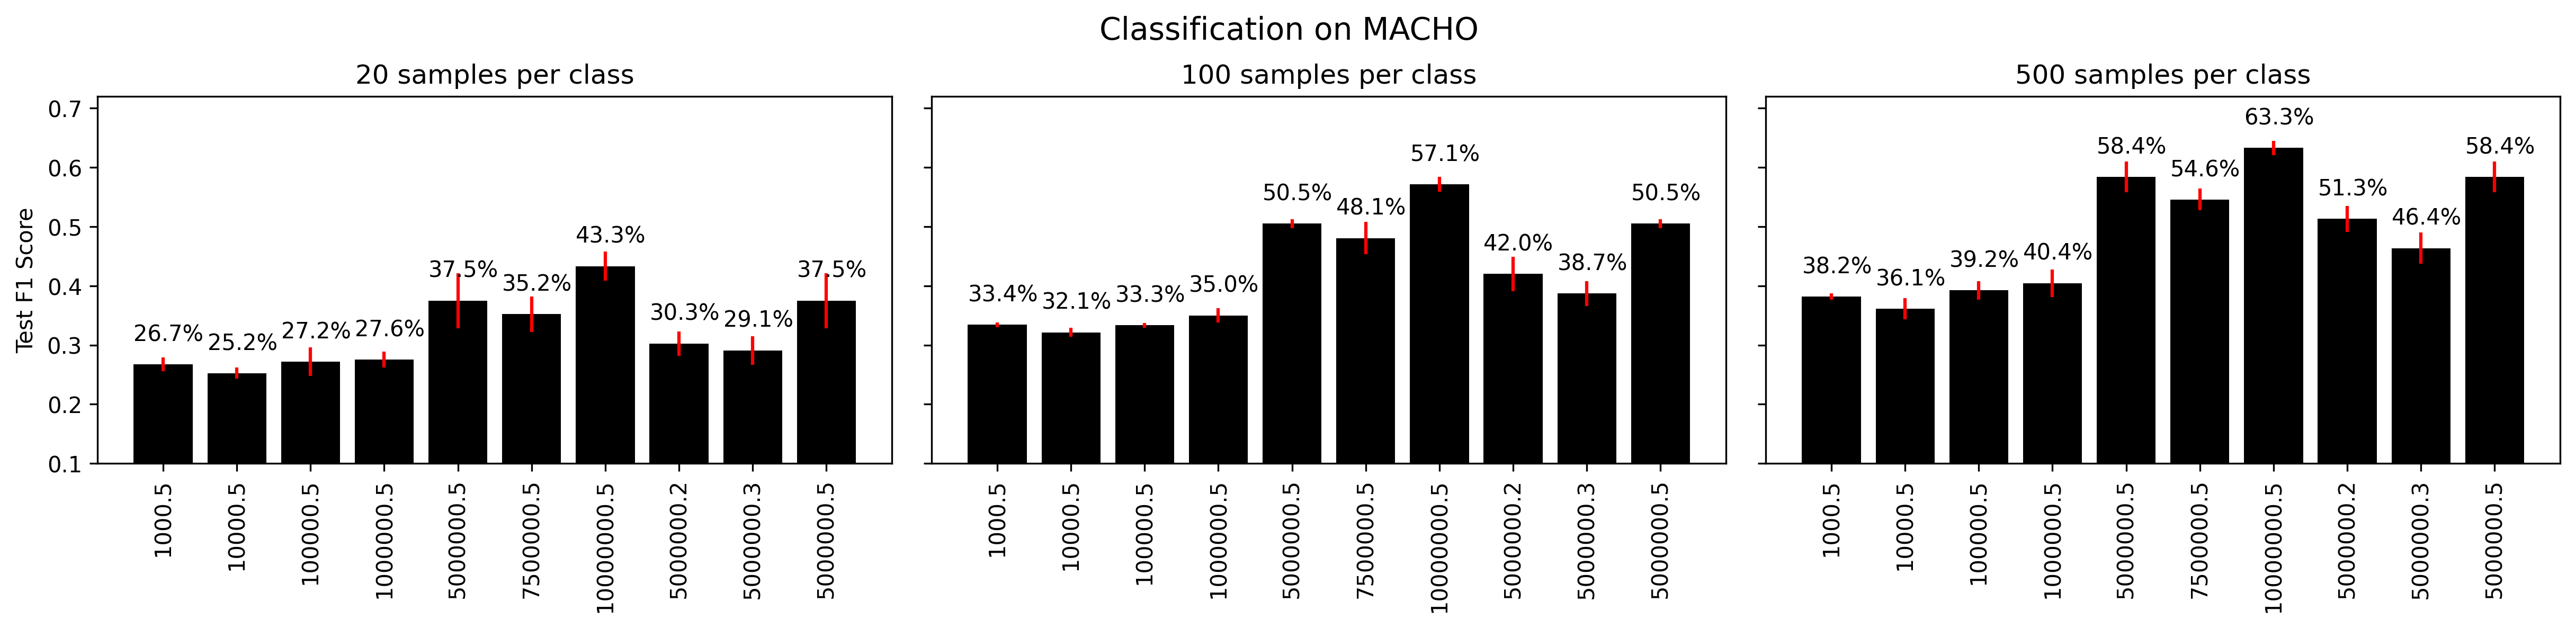

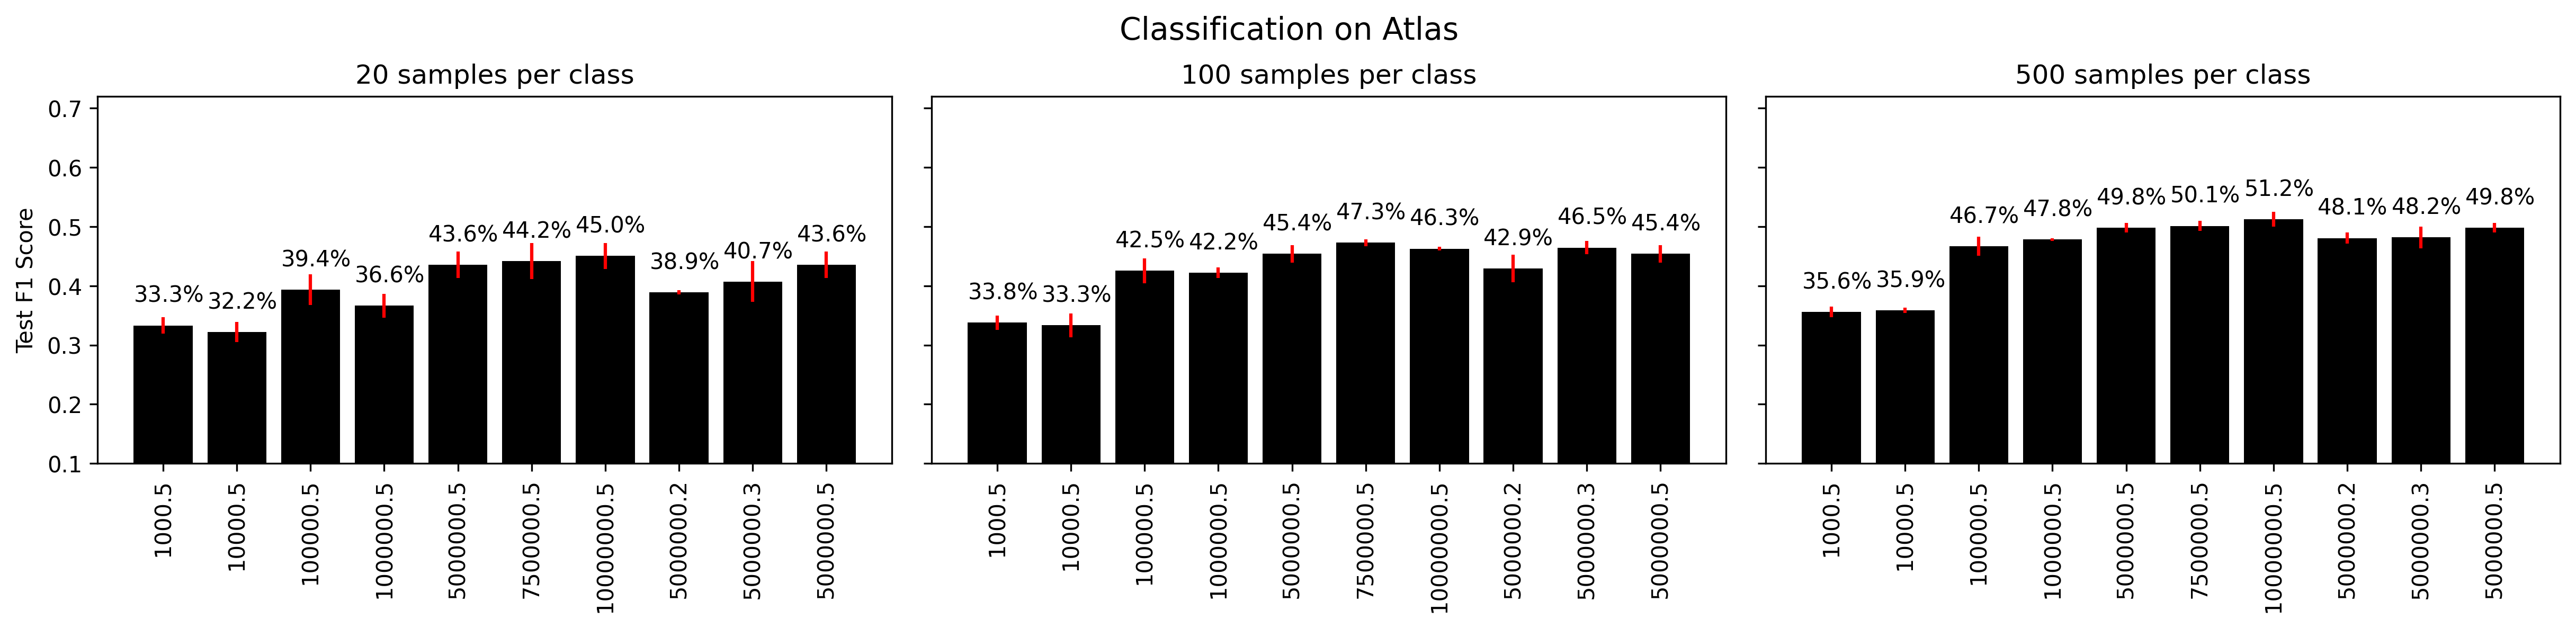

In [101]:
for group0, df0 in test_metrics.groupby('data'):
    fig, axes = plt.subplots(1, 3, figsize=(20, 3), sharey=True, dpi=300, gridspec_kw={'wspace': 0.05})
    for k, (group1, df1) in enumerate(df0.groupby('spc')):
        x_lab = [x.split('_')[-1] for x in df1['exp_name'].values]
        x_lab = [x.split('_')[-1]+str(p) for x, p in zip(df1['exp_name'].values, df1['probed'].values)]
        xticks = range(len(x_lab))
        axes[k].bar(xticks, df1['mean'], yerr=df1['std'], color='k', ecolor='red')
        axes[k].set_xticks(xticks)
        axes[k].set_xticklabels(x_lab, rotation=90)
        axes[k].set_title('{} samples per class'.format(group1))
        axes[k].set_ylim(0.1, 0.72)
        for i, value in enumerate(df1['mean']):
            axes[k].text(i-0.4, value+0.04, '{:.1f}%'.format(value*100) )
    
    axes[0].set_ylabel('Test F1 Score')
    
    if group0 == 'alcock': title = 'Classification on MACHO'
    if group0 == 'atlas': title = 'Classification on Atlas'
        
    fig.text(0.5, 1., title, ha='center', fontsize=14)
    fig.savefig('./presentation/figures/clf_vs_nsamples_{}.png'.format(group0), bbox_inches='tight')  